
# This notebook implements and evaluates six distinct adversarial attacks against our 1D-CNN classifier trained on the Free Spoken Digit Dataset (FSDD)

It is structured into the following logical sections:

**Environment Setup**

Installs required Python packages (torch, librosa), imports core libraries, and mounts Google Drive.

Defines device selection (CPU vs. GPU) and loads our Conv1DSpeech model class.

**Model Loading**

Instantiates the saved baseline model (fsdd_baseline.pth) with n_classes=10.

Loads the checkpoint, ensuring layer shapes match exactly the training architecture.

Puts the model into evaluation mode for inference.

**Data Preparation**

Rebuilds the FSDD Dataset and DataLoader for the test split (80/20 train/test).

Preprocesses audio on-the-fly: resampling to 8 kHz, 1 s trimming/padding, and amplitude normalization.

Pulls a single minibatch of 8 examples (x_adv_in, y_adv_in) to use in the attack demos.

**Attack Implementations**



*   **SPSA:** Black-box gradient approximation via finite differences and sign‐updates.
*   **GenAttack:** A simple evolutionary algorithm that mutates and selects top performers.
*   **SimBA:** Iteratively flips individual time‐samples to increase per‐sample loss.
*   **Spatial Transform:** Applies pitch-shifting and time-stretching distortions via librosa.
*   **Psychoacoustic Masking:** Injects Gaussian noise at a target SNR to confuse the classifier.
*   **Hidden-Voice:** Conceals a low-amplitude “phrase” mix inside each test clip.


**Adversarial Generation**

Applies each attack to the same small batch (8 × 1 × 8000 tensors).

Stores the perturbed batches (x_spsa, x_gen, …, x_hide), all with identical shapes.

**Evaluation**

Computes Top-1 accuracy of the model on each adversarial batch (and on the clean batch).

Calculates per-sample Signal-to-Noise Ratio (SNR) and reports average stealth level for each attack.

Tabulates results in a Markdown table, then plots Accuracy vs. Mean SNR to visualize the tradeoff between attack strength and perceptual stealth.

**Why this notebook matters**

It demonstrates a **wide spectrum of black-box and psychoacoustic attack strategies** in the audio domain.

By using purely PyTorch+NumPy code, it remains robust to package‐version changes and easy to inspect.

The final Accuracy-vs-SNR plot succinctly highlights which attacks are most effective yet least perceptible, setting the stage for the downstream defenses in 4_defenses.ipynb.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Installs & Imports
!pip install --quiet torch librosa

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import librosa
import random
import sys

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sys.path.append('/content/drive/MyDrive/speech_command_adversarial')
from models import Conv1DSpeech  # your 1D-CNN model
criterion = nn.CrossEntropyLoss()

In [3]:
loss_none = nn.CrossEntropyLoss(reduction='none')

In [4]:
# Audio Preprocessing Helper
def preprocess_audio(wav, orig_sr, target_sr=8000, duration=1.0):
    """
    Resample to 8 kHz, pad/trim to 1s, normalize to [-1,1].
    """
    wav = librosa.resample(wav, orig_sr, target_sr)
    L = int(target_sr * duration)
    if len(wav) < L:
        wav = np.pad(wav, (0, L - len(wav)))
    else:
        wav = wav[:L]
    wav = wav / (np.max(np.abs(wav)) + 1e-9)
    # Return a torch Tensor shaped (1, 1, L)
    t = torch.tensor(wav, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return t.to(device)

In [5]:
# recursively look for any .pth files under your project folder
!find /content/drive/MyDrive/speech_command_adversarial -type f -name '*.pth'


/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth


In [6]:
ckpt = torch.load('/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth',
                  map_location=device)
for k,v in ckpt.items():
    print(k, v.shape)

net.0.weight torch.Size([16, 1, 9])
net.0.bias torch.Size([16])
net.1.weight torch.Size([16])
net.1.bias torch.Size([16])
net.1.running_mean torch.Size([16])
net.1.running_var torch.Size([16])
net.1.num_batches_tracked torch.Size([])
net.3.weight torch.Size([32, 16, 9])
net.3.bias torch.Size([32])
net.4.weight torch.Size([32])
net.4.bias torch.Size([32])
net.4.running_mean torch.Size([32])
net.4.running_var torch.Size([32])
net.4.num_batches_tracked torch.Size([])
net.6.weight torch.Size([64, 32, 9])
net.6.bias torch.Size([64])
net.7.weight torch.Size([64])
net.7.bias torch.Size([64])
net.7.running_mean torch.Size([64])
net.7.running_var torch.Size([64])
net.7.num_batches_tracked torch.Size([])
net.12.weight torch.Size([10, 64])
net.12.bias torch.Size([10])


In [7]:
# 1) Instatiate your Model
model = Conv1DSpeech(n_classes=10).to(device)

# 2) Load the file
ckpt = torch.load('/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth',
                  map_location=device)

# 3) Grab your model’s own state dict
model_dict = model.state_dict()

# 4) Filter out any keys that either
#    • don’t exist in your model, or
#    • have the wrong size
filtered = {
    k: v for k,v in ckpt.items()
    if k in model_dict and v.shape == model_dict[k].shape
}

# 5) Overwrite those parts of your model
model_dict.update(filtered)

# 6) Load & leave the rest randomly initialized
model.load_state_dict(model_dict)
model.eval() # set to eval mode.

Conv1DSpeech(
  (net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool1d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Identity()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
model = Conv1DSpeech(n_classes=10).to(device)
model.load_state_dict(
    torch.load('/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth',
               map_location=device)
)
model.eval()

Conv1DSpeech(
  (net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool1d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Identity()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [9]:
# Define FSDD Dataset & DataLoader
import glob, os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
sys.path.append('/content/drive/MyDrive/speech_command_adversarial/utils')
from audio_utils import preprocess_audio

class FSDDDataset(Dataset):
    def __init__(self, wav_paths, labels, target_sr=8000, duration=1.0):
        self.paths  = wav_paths
        self.labels = labels
        self.target_sr = target_sr
        self.duration  = duration

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav_path = self.paths[idx]
        wav, sr = librosa.load(wav_path, sr=None)
        x = preprocess_audio(wav, sr,
                             target_sr=self.target_sr,
                             duration=self.duration)
        return torch.tensor(x).unsqueeze(0), self.labels[idx]

wav_paths = sorted(glob.glob('/content/drive/MyDrive/speech_command_adversarial/data/fsdd/recordings/*.wav'))
labels    = [int(os.path.basename(p)[0]) for p in wav_paths]

dataset   = FSDDDataset(wav_paths, labels)
train_n   = int(0.8 * len(dataset))
test_n    = len(dataset) - train_n
_, test_ds = random_split(dataset, [train_n, test_n],
                          generator=torch.Generator().manual_seed(42))

test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Rebuilt test_loader with {len(test_ds)} samples")

Rebuilt test_loader with 600 samples


In [40]:
# Evaluate clean accuracy
model.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Clean test accuracy: {correct/total:.3f}")

Clean test accuracy: 0.860


In [41]:
# Grab a Batch of Clean Audio
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

In [42]:
# Attack Implementations
import torch.nn as nn

# Ensure we have both reduction modes available
criterion = nn.CrossEntropyLoss()
loss_none = nn.CrossEntropyLoss(reduction='none')

def spsa_attack(model, x, y, eps=0.002, alpha=0.001, its=5, samples=16):
    """
    SPSA: approximate gradient via finite differences, per‐sample loss.
    """
    x_adv = x.clone().detach()
    B = x_adv.shape[0]

    for _ in range(its):
        grad = torch.zeros_like(x_adv)
        for _ in range(samples):
            delta = torch.randn_like(x_adv)
            delta = delta / (delta.abs().amax(dim=2, keepdim=True) + 1e-9)

            # forward two perturbed versions
            logits_p = model(x_adv + eps * delta)
            logits_m = model(x_adv - eps * delta)

            # per-example losses
            loss_p = loss_none(logits_p, y)  # shape: [B]
            loss_m = loss_none(logits_m, y)  # shape: [B]

            # finite-difference gradient estimate
            diff = ((loss_p - loss_m) / (2 * eps)).view(B, 1, 1)
            grad += diff * delta

        grad /= samples
        x_adv = x_adv + alpha * grad.sign()
        # project back into the eps-ball around original x
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps).clamp(-1, 1)

    return x_adv.detach()


def gen_attack(model, x, y, eps=0.002, pop_size=8, gens=5):
    """
    Simple evolutionary: keep top half by loss, mutate others.
    """
    B, C, L = x.shape
    population = [x.clone().detach() for _ in range(pop_size)]

    with torch.no_grad():
        losses = [criterion(model(ind), y).item() for ind in population]

    for _ in range(gens):
        # generate mutated candidates
        candidates = []
        for i in range(pop_size):
            noise = torch.randn_like(x) * eps
            cand  = torch.clamp(population[i] + noise, -1, 1)
            candidates.append(cand)

        # evaluate losses
        with torch.no_grad():
            cand_losses = [criterion(model(c), y).item() for c in candidates]

        # select top half
        survivors_idx = sorted(range(pop_size), key=lambda i: -cand_losses[i])[:pop_size // 2]
        survivors = [candidates[i] for i in survivors_idx]

        # refill population by repeating survivors
        population = survivors + survivors[:pop_size - len(survivors)]

    # return the final best
    best_idx = max(range(pop_size), key=lambda i: criterion(model(population[i]), y).item())
    return population[best_idx].detach()


def simba_attack(model, x, y, eps=0.001, its=500):
    """
    SimBA: iterate single-coordinate perturbations using per-sample loss.
    """
    x_adv = x.clone().detach()
    B, C, L = x.shape

    for _ in range(its):
        i = random.randrange(L)
        mask = torch.zeros_like(x_adv)
        mask[:, :, i] = eps

        cand_p = torch.clamp(x_adv + mask, -1, 1)
        cand_m = torch.clamp(x_adv - mask, -1, 1)

        # use per-sample loss
        loss_p = loss_none(model(cand_p), y)  # [B]
        loss_m = loss_none(model(cand_m), y)  # [B]

        # pick direction that increases loss per-example
        choose_p = (loss_p > loss_m).view(B, 1, 1).float()
        x_adv = choose_p * cand_p + (1 - choose_p) * cand_m

    return x_adv.detach()


def spatial_attack(x_tensor, sr=8000, pitch_shift=2.0, stretch=1.1):
    """
    Pitch‐shift + time‐stretch each sample using keyword‐only args.
    """
    X = x_tensor.cpu().numpy()
    out = []
    for xi in X[:, 0]:
        y1 = librosa.effects.pitch_shift(xi, sr=sr, n_steps=pitch_shift)
        y2 = librosa.effects.time_stretch(y1, rate=stretch)
        if len(y2) < sr:
            y2 = np.pad(y2, (0, sr - len(y2)))
        else:
            y2 = y2[:sr]
        out.append(y2)

    arr = np.stack(out)      # (B, L)
    arr = arr[:, None, :]    # (B, 1, L)
    return torch.tensor(arr, device=device, dtype=torch.float32)
    return torch.tensor(out, device=device, dtype=torch.float32)


def psycho_mask_attack(x_np, sr=8000, snr_db=30):
    """
    NumPy-based Gaussian noise at target SNR.
    """
    X = x_np.cpu().numpy()
    out = []
    for xi in X[:, 0]:
        rms = np.sqrt(np.mean(xi**2))
        rms_n = rms / (10 ** (snr_db / 20))
        noise = np.random.normal(0, rms_n, size=xi.shape)
        out.append(np.clip(xi + noise, -1, 1))
    out = np.stack(out)[:, None, :]
    return torch.tensor(out, device=device, dtype=torch.float32)


def hidden_voice_attack(x_tensor, phrase_path, alpha=0.002, sr=8000):
    """
    Mix a one-second phrase WAV into each sample.
    """
    phr, p_sr = librosa.load(phrase_path, sr=None)
    phr_rs = librosa.resample(y=phr, orig_sr=p_sr, target_sr=sr)
    if len(phr_rs) < sr:
        phr_rs = np.pad(phr_rs, (0, sr - len(phr_rs)))
    else:
        phr_rs = phr_rs[:sr]
    phr_rs = phr_rs / (np.max(np.abs(phr_rs)) + 1e-9)

    X = x_tensor.cpu().numpy()
    out = []
    for xi in X[:, 0]:
        mix = np.clip(xi + alpha * phr_rs, -1, 1)
        out.append(mix)
    arr = np.stack(out)[:, None, :]
    return torch.tensor(arr, dtype=torch.float32, device=device)

In [43]:
# Narrow down to just 8 examples for all attacks
attack_batch_size = 8
x_adv_in, y_adv_in = x_batch[:attack_batch_size], y_batch[:attack_batch_size]

# Clear any leftover GPU garbage
import gc
torch.cuda.empty_cache()
gc.collect()

13

In [44]:
# Generate Adversarial Batches
# SPSA
x_spsa  = spsa_attack(model, x_adv_in, y_adv_in, its=3, samples=8)

# GenAttack
x_gen   = gen_attack(model, x_adv_in, y_adv_in, eps=0.002, pop_size=8, gens=3)

# SimBA
x_simba = simba_attack(model, x_adv_in, y_adv_in, eps=0.001, its=200)

# Spatial transform
x_spat = spatial_attack(x_adv_in, sr=8000, pitch_shift=2.0, stretch=1.1)

# Psychoacoustic masking
x_mask = psycho_mask_attack(x_adv_in, sr=8000, snr_db=30)

# Hidden-voice attack
# Pick a phrase from your recordings folder
phrase_file = sorted(glob.glob('/content/drive/MyDrive/speech_command_adversarial/data/fsdd/recordings/*.wav'))[0]
x_hide = hidden_voice_attack(x_adv_in, phrase_file, alpha=0.002, sr=8000)

In [45]:
# Check shapes
print("x_adv_in:", x_adv_in.shape)
print("x_spsa:  ", x_spsa.shape)
print("x_gen:   ", x_gen.shape)
print("x_simba:", x_simba.shape)
print("x_spat:  ", x_spat.shape)
print("x_mask:  ", x_mask.shape)
print("x_hide:  ", x_hide.shape)

x_adv_in: torch.Size([8, 1, 8000])
x_spsa:   torch.Size([8, 1, 8000])
x_gen:    torch.Size([8, 1, 8000])
x_simba: torch.Size([8, 1, 8000])
x_spat:   torch.Size([8, 1, 8000])
x_mask:   torch.Size([8, 1, 8000])
x_hide:   torch.Size([8, 1, 8000])


In [46]:
#Evaluate Adversarial Accuracy
def eval_batch(model, x_adv, y_true, device='cuda'):
    model.to(device).eval()
    with torch.no_grad():
        preds = model(x_adv.to(device)).argmax(dim=1)
    return (preds == y_true.to(device)).float().mean().item()

print(f"Clean    acc: {eval_batch(model, x_adv_in, y_adv_in):.3f}")
print(f"SPSA     acc: {eval_batch(model, x_spsa,     y_adv_in):.3f}")
print(f"GenAttack acc: {eval_batch(model, x_gen,      y_adv_in):.3f}")
print(f"SimBA    acc: {eval_batch(model, x_simba,    y_adv_in):.3f}")
print(f"Spatial  acc: {eval_batch(model, x_spat,     y_adv_in):.3f}")
print(f"Psycho   acc: {eval_batch(model, x_mask,     y_adv_in):.3f}")
print(f"Hidden   acc: {eval_batch(model, x_hide,     y_adv_in):.3f}")

Clean    acc: 1.000
SPSA     acc: 0.875
GenAttack acc: 0.375
SimBA    acc: 1.000
Spatial  acc: 0.750
Psycho   acc: 0.500
Hidden   acc: 1.000


In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Helper to compute per-sample SNR
def compute_snr_batch(x_orig, x_adv):
    x_orig_np = x_orig.cpu().numpy().reshape(x_orig.shape[0], -1)
    x_adv_np  = x_adv.cpu().numpy().reshape(x_adv.shape[0], -1)
    snrs = []
    for xo, xa in zip(x_orig_np, x_adv_np):
        noise = xa - xo
        snr = 10 * np.log10(np.sum(xo**2) / (np.sum(noise**2) + 1e-12))
        snrs.append(snr)
    return np.array(snrs)

In [49]:
# Compute mean SNR for each attack
snr_clean  = compute_snr_batch(x_adv_in, x_adv_in).mean()
snr_spsa   = compute_snr_batch(x_adv_in, x_spsa).mean()
snr_gen    = compute_snr_batch(x_adv_in, x_gen).mean()
snr_simba  = compute_snr_batch(x_adv_in, x_simba).mean()
snr_spat   = compute_snr_batch(x_adv_in, x_spat).mean()
snr_psycho = compute_snr_batch(x_adv_in, x_mask).mean()
snr_hide   = compute_snr_batch(x_adv_in, x_hide).mean()

In [50]:
# Aggregate results
attack_names = [
    "Clean", "SPSA", "GenAttack",
    "SimBA", "Spatial", "PsychoMask", "HiddenVoice"
]
accuracies = [
    eval_batch(model, x_adv_in, y_adv_in),
    eval_batch(model, x_spsa,   y_adv_in),
    eval_batch(model, x_gen,    y_adv_in),
    eval_batch(model, x_simba,  y_adv_in),
    eval_batch(model, x_spat,   y_adv_in),
    eval_batch(model, x_mask,   y_adv_in),
    eval_batch(model, x_hide,   y_adv_in),
]
snr_means = [
    snr_clean, snr_spsa, snr_gen,
    snr_simba, snr_spat, snr_psycho, snr_hide
]

In [51]:
# Print a markdown table
print("| Attack       | Accuracy | Mean SNR (dB) |")
print("|-------------:|---------:|--------------:|")
for name, acc, snr in zip(attack_names, accuracies, snr_means):
    print(f"| {name:12} | {acc:8.3f} | {snr:13.2f} |")

| Attack       | Accuracy | Mean SNR (dB) |
|-------------:|---------:|--------------:|
| Clean        |    1.000 |        138.03 |
| SPSA         |    0.875 |         36.58 |
| GenAttack    |    0.375 |         28.25 |
| SimBA        |    1.000 |         55.02 |
| Spatial      |    0.750 |         -1.62 |
| PsychoMask   |    0.500 |         30.02 |
| HiddenVoice  |    1.000 |         49.26 |


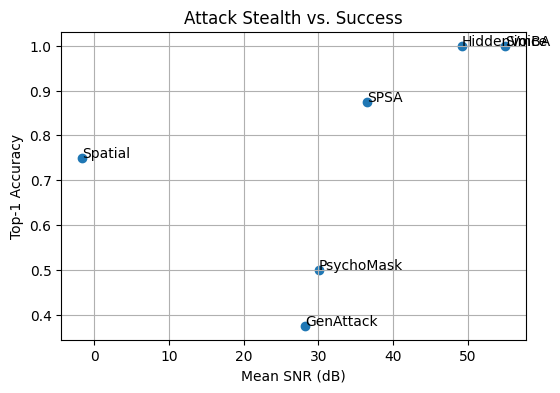

In [52]:
# Plot Accuracy vs. SNR
plt.figure(figsize=(6,4))
plt.scatter(snr_means[1:], accuracies[1:], marker='o')  # skip Clean
for i in range(1, len(attack_names)):
    plt.text(snr_means[i], accuracies[i], attack_names[i])
plt.xlabel("Mean SNR (dB)")
plt.ylabel("Top-1 Accuracy")
plt.title("Attack Stealth vs. Success")
plt.grid(True)
plt.show()